In [2]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib
import matplotlib.pyplot as plt

### Functions for model

In [ ]:
# Dataset and Transformations
class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        img = T.Resize((self.size, self.size))(img)
        return img, target

class RoboflowDataset(Dataset):
    def __init__(self, root, folder='train', transforms=None):
        self.root = root
        self.transforms = transforms
        self.folder = folder
        if not folder in ['test', 'train', 'valid']:
            print("Invalid folder parameter. Must be 'valid', 'test' or 'train'. Using default train folder.") 
            self.folder = "train"
            
        self.imgs = sorted(os.listdir(os.path.join(root, f"{self.folder}/images")))
        self.annotations = sorted(os.listdir(os.path.join(root, f"{self.folder}/labels")))

        # Filter images with valid annotations
        self.data = []
        for img, ann in zip(self.imgs, self.annotations):
            ann_path = os.path.join(root, f"{self.folder}/labels", ann)
            if os.path.exists(ann_path):
                with open(ann_path, 'r') as f:
                    lines = f.readlines()
                if len(lines) > 0:  # Check if there are any annotations
                    self.data.append((img, ann))

        self.to_tensor = T.ToTensor()

    def __getitem__(self, idx):
        img_name, ann_name = self.data[idx]
        img_path = os.path.join(self.root, f"{self.folder}/images", img_name)
        ann_path = os.path.join(self.root, f"{self.folder}/labels", ann_name)

        img = Image.open(img_path).convert("RGB")
        img = self.to_tensor(img)

        # Parse YOLO annotations
        with open(ann_path, 'r') as f:
            lines = f.readlines()

        boxes = []
        labels = []
        for line in lines:
            label, x_center, y_center, width, height = map(float, line.strip().split())
            xmin = (x_center - width / 2) * img.shape[2]
            xmax = (x_center + width / 2) * img.shape[2]
            ymin = (y_center - height / 2) * img.shape[1]
            ymax = (y_center + height / 2) * img.shape[1]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(label))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Exclude entries with no boxes
        if boxes.numel() == 0:
            raise ValueError(f"Empty boxes for image {img_name}")

        target = {"boxes": boxes, "labels": labels}
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.data)

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Metric Evaluation
def evaluate_model(model, dataloader, device, cls=None):
    model.eval()
    metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75, 0.95])  # mAP@50, @75, @50-95

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            preds = []
            gt = []

            for output, target in zip(outputs, targets):
                if cls is not None:
                    mask = output["labels"] == cls
                    output = {key: value[mask] for key, value in output.items()}
                    mask = target["labels"] == cls
                    target = {key: value[mask] for key, value in target.items()}

                preds.append({
                            "boxes": output["boxes"].cpu(),
                            "scores": output["scores"].cpu(),
                            "labels": output["labels"].cpu()
                        })
                
                gt.append({
                            "boxes": target["boxes"].cpu(),
                            "labels": target["labels"].cpu()
                        })

            metric.update(preds, gt)

    results = metric.compute()
    print(f"mAP@50: {results['map_50']:.4f}, mAP@50-95: {results['map']:.4f}")
    return results

# Collate Function
def collate_fn(batch):
    return tuple(zip(*batch))

### Plot mAP graph

In [3]:
import csv

def read_rcnn_csv(path):
    # Initialize lists to store the mAP values and epochs
    epochs = []
    train_map_50 = []
    train_map_50_95 = []
    test_map_50 = []
    test_map_50_95 = []

    # Read the CSV file and extract the data
    with open(path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            epochs.append(int(row[0]))
            train_map_50.append(float(row[4]))
            train_map_50_95.append(float(row[5]))
            test_map_50.append(float(row[6]))
            test_map_50_95.append(float(row[7]))
    
    return epochs, train_map_50, train_map_50_95, test_map_50, test_map_50_95

def read_yolo_csv(path):
    dd = {}
    headers = []
    with open(path, newline="") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if dd == {}:
                for i in range(len(row)):
                    dd[row[i]] = [] 
                    headers.append(row[i])
            else:
                for i in range(len(row)):
                    dd[headers[i]].append(row[i])
    return dd


data_dict = read_yolo_csv("yolov8s_training_stats.csv")

print(data_dict.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'yolov8s_training_stats.csv'

In [4]:
import matplotlib.pyplot as plt

# Define the CSV file path
rcnn_file = 'rcnn_training_stats.csv'
yolo_file = '/home/s14-htx/Documents/GitHub/GPU_file_sharing/yolo_adamax_training_stats.csv'
# yolo_file = 'yolov8s_training_stats.csv'

epochs, train_map_50, train_map_50_95, test_map_50, test_map_50_95 = read_rcnn_csv(rcnn_file)
yolo_data = read_yolo_csv(yolo_file)

# print(max(test_map_50_95))
# print(max(yolo_data["metrics/mAP50-95(B)"]))
print(max(test_map_50))
print(max(yolo_data["metrics/mAP50(B)"]))

# Plotting the mAP values over epochs
plt.figure(figsize=(10, 6))

# Plot test set mAP@50
plt.plot(epochs, test_map_50, label="Faster-RCNN ResNet50") # fasterrcnn_resnet50_fpn
plt.plot(epochs, [float(i) for i in yolo_data["metrics/mAP50(B)"]], label="YOLOv8s")

# Plot test set mAP@50-95
# plt.plot(epochs, test_map_50_95, label="Faster-RCNN ResNet50") # fasterrcnn_resnet50_fpn
# plt.plot(epochs, [float(i) for i in yolo_data["metrics/mAP50-95(B)"]], label="YOLOv8s")

# Plot mAP@50 and mAP@50-95 for Train and Test sets
# plt.plot(epochs, train_map_50, label="Train mAP@50", marker='o')
# plt.plot(epochs, train_map_50_95, label="Train mAP@50-95", marker='o')
# plt.plot(epochs, test_map_50, label="Test mAP@50", marker='x')
# plt.plot(epochs, test_map_50_95, label="Test mAP@50-95", marker='x')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("mAP@50-95 over Epochs for Faster-RCNN ResNet50 and YOLOv8s")
plt.legend(loc="best")
plt.grid(True)

plt.ylim(0,1)
plt.xlim(0, max(epochs))

# Show the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'rcnn_training_stats.csv'

0.60375
0.61631
0.59729


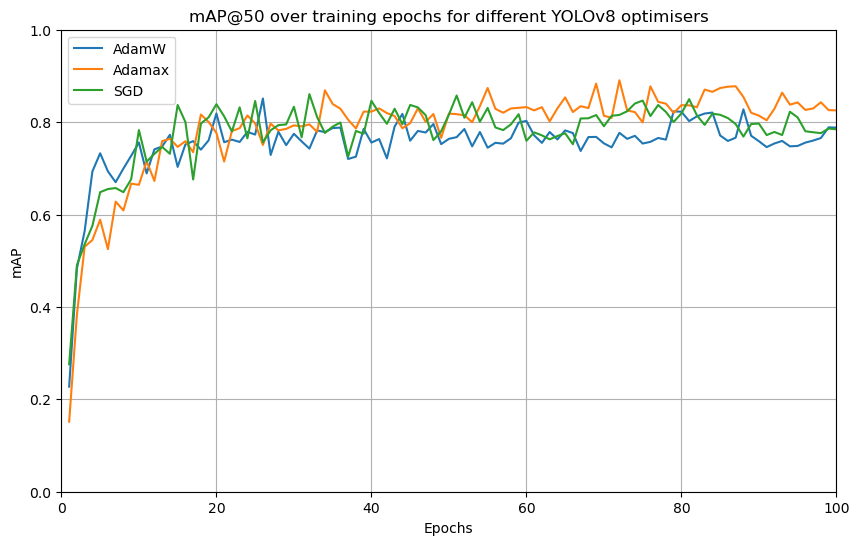

In [ ]:
import matplotlib.pyplot as plt

# Define the CSV file path
adamw_file = 'yolov8s_training_stats.csv'
sgd_file = "/home/s14-htx/Documents/GitHub/GPU_file_sharing/runs/detect/train4/results.csv"
adamax_file = '/home/s14-htx/Documents/GitHub/GPU_file_sharing/yolo_adamax_training_stats.csv'
# yolo_file = 'yolov8s_training_stats.csv'

# epochs, train_map_50, train_map_50_95, test_map_50, test_map_50_95 = read_rcnn_csv(rcnn_file)
# yolo_data = read_yolo_csv(yolo_file)


adamw_data = read_yolo_csv(adamw_file)
adamax_data = read_yolo_csv(adamax_file)
sgd_data = read_yolo_csv(sgd_file)

print(max(adamw_data["metrics/mAP50-95(B)"]))
print(max(adamax_data["metrics/mAP50-95(B)"]))
print(max(sgd_data["metrics/mAP50-95(B)"]))

# Plotting the mAP values over epochs
plt.figure(figsize=(10, 6))

# Plot test set mAP@50
plt.plot(epochs,[float(i) for i in adamw_data["metrics/mAP50(B)"]], label="AdamW") # fasterrcnn_resnet50_fpn
plt.plot(epochs, [float(i) for i in adamax_data["metrics/mAP50(B)"]], label="Adamax")
plt.plot(epochs, [float(i) for i in sgd_data["metrics/mAP50(B)"]], label="SGD")


# Plot test set mAP@50-95
# plt.plot(epochs, test_map_50_95, label="Faster-RCNN ResNet50") # fasterrcnn_resnet50_fpn
# plt.plot(epochs, [float(i) for i in yolo_data["metrics/mAP50-95(B)"]], label="YOLOv8s")

# Plot mAP@50 and mAP@50-95 for Train and Test sets
# plt.plot(epochs, train_map_50, label="Train mAP@50", marker='o')
# plt.plot(epochs, train_map_50_95, label="Train mAP@50-95", marker='o')
# plt.plot(epochs, test_map_50, label="Test mAP@50", marker='x')
# plt.plot(epochs, test_map_50_95, label="Test mAP@50-95", marker='x')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("mAP@50 over training epochs for different YOLOv8 optimisers")
plt.legend(loc="best")
plt.grid(True)

plt.ylim(0,1)
plt.xlim(0, max(epochs))

# Show the plot
plt.show()

### Visualisation Functions

In [3]:
import random
import numpy as np
import cv2
from ultralytics import YOLO

class_dict = {
    0: "ERP",
    1: "GIVE_WAY",
    2: "INFO_ONE_WAY",
    3: "MANDATORY_KEEP_LEFT",
    4: "MANDATORY_SPLIT_WAY",
    5: "NO_ENTRY",
    6: "NO_LEFT_TURN",
    7: "NO_RIGHT_TURN",
    8: "NO_STOPPING",
    9: "NO_WAITING",
    10: "PEDESTARIAN_CROSSING",
    11: "PEDESTARIAN_USE_CROSSING",
    12: "PROHIBITORY_NO_JAYWALKING",
    13: "PROHIBITORY_SPD_LIMIT",
    14: "PROHIB_NO_VEH_OVER_HEIGHT_45",
    15: "REDUCE_SPEED_NOW",
    16: "SLOW",
    17: "STOP",
    18: "TURN_ARROW",
    19: "U_TURN",
    20: "WARNING_CURVE",
}

def visualize_image_with_boxes(img, boxes, scores, labels, show=False):
    """
    Visualize a single image with bounding boxes.
    :param img: Image as a NumPy array (HWC)
    :param boxes: Bounding boxes as a NumPy array [[xmin, ymin, xmax, ymax], ...]
    :param scores: Confidence scores as a NumPy array
    :param labels: Labels as a NumPy array
    """
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin

        # Create a rectangle patch
        rect = matplotlib.patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add label and score
        label = f"{labels[i]}: {scores[i]:.2f}"
        ax.text(xmin, ymin - 10, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    # Convert the figure to a NumPy array
    fig.canvas.draw()  # Draw the canvas
    img_with_boxes = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_with_boxes = img_with_boxes.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    if show:
        plt.show()

    plt.close(fig)  # Close the plot to free resources

    return img_with_boxes

def draw_boxes(img, boxes, scores, labels, show=False):
    """
    Visualize a single image with bounding boxes using OpenCV.
    :param img: Image as a NumPy array (HWC)
    :param boxes: Bounding boxes as a NumPy array [[xmin, ymin, xmax, ymax], ...]
    :param scores: Confidence scores as a NumPy array
    :param labels: Labels as a NumPy array
    :param show: Boolean to show the image after drawing boxes
    """
    # Make a copy of the image to draw on
    img_with_boxes = img.copy()

    # Iterate through each bounding box, label, and score
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

        # Draw the rectangle (using BGR color format for OpenCV)
        color = (0, 0, 255)  # Red in BGR format for bounding box
        thickness = 2
        img_with_boxes = cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), color, thickness)

        # Prepare the label with the score
        label = f"{class_dict[int(labels[i])]}: {scores[i]:.2f}"

        # Set font for the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_thickness = 2
        text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
        text_width, text_height = text_size

        # Draw background for text
        text_bg = (0, 0, 255)  # Red background for text box
        img_with_boxes = cv2.rectangle(img_with_boxes, (xmin, ymin - text_height - 10), (xmin + text_width, ymin), text_bg, -1)

        # Put the label text on the image
        text_color = (255, 255, 255)  # White color for the text
        img_with_boxes = cv2.putText(img_with_boxes, label, (xmin, ymin - 5), font, font_scale, text_color, font_thickness)

        img_with_boxes = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    if show:
        # Display the image with bounding boxes
        cv2.imshow('Image with Bounding Boxes', img_with_boxes)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return img_with_boxes


def visualize_predictions(model, img_paths, device, transforms=None, img_size=800, threshold=0.5, show=False):
    model.eval()
    img_arrs = []

    with torch.no_grad():
        for i, img_path in enumerate(img_paths):
            img = Image.open(img_path).convert("RGB")
            to_tensor = T.ToTensor()
            img = to_tensor(img)
            if transforms: 
                img, _ = transforms(img, {})
            img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension

            # Perform inference
            output = model(img_tensor)[0]

            # Convert tensors to numpy for visualization
            img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert image to HWC
            img_np = (img_np * 255).astype('uint8')  # Scale to [0, 255]

            # Extract predictions above the confidence threshold
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            high_conf_idx = scores > threshold
            boxes = boxes[high_conf_idx]
            scores = scores[high_conf_idx]
            labels = labels[high_conf_idx]

            # Visualize the image and predictions
            img_arr = draw_boxes(img_np, boxes, scores, labels, show=show)
            img_arrs.append(img_arr)

            cv2.imwrite(f"rcnn_result_{i}.jpg", img_arr)

    return img_arrs
            

def visualize_predictions_randomized(model, dataset, device, num_images=5, threshold=0.5):
    """
    Visualize predictions on randomly selected test images.
    :param model: Trained Faster R-CNN model
    :param dataset: The test dataset (not DataLoader, so we can randomly index)
    :param device: Torch device (CPU or CUDA)
    :param num_images: Number of test images to visualize
    :param threshold: Confidence threshold for predictions
    """
    model.eval()  # Set model to evaluation mode

    # Select random indices
    random_indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in random_indices:
            img, target = dataset[idx]
            img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension

            # Perform inference
            output = model(img_tensor)[0]

            # Convert tensors to numpy for visualization
            img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert image to HWC
            img_np = (img_np * 255).astype('uint8')  # Scale to [0, 255]

            # Extract predictions above the confidence threshold
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            high_conf_idx = scores > threshold
            boxes = boxes[high_conf_idx]
            scores = scores[high_conf_idx]
            labels = labels[high_conf_idx]

            # Visualize the image and predictions
            visualize_image_with_boxes(img_np, boxes, scores, labels)

def get_predictions_yolo(weights_path, img_paths, img_size=800, threshold=0.5):
    # Load a model
    model = YOLO(weights_path)  # pretrained YOLO11n model

    # Run batched inference on a list of images
    results = model(img_paths, conf=threshold)  # return a list of Results objects
    print(results)

    # Process results list
    for i, result in enumerate(results):
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs
        obb = result.obb  # Oriented boxes object for OBB outputs
        result.show()  # display to screen
        result.save(filename=f"yolo_result_{i}.jpg")  # save to disk


In [4]:
from util import plot_imgs
import cv2

# Visualize random predictions from the test dataset
model = get_model(num_classes=22)
model.load_state_dict(torch.load("/home/s14-htx/Documents/GitHub/SG-Road-Signs-Detection/models/RCNN_100_16.pth", weights_only=True))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Params
img_size = 800
conf_threshold = 0.1

# Dataset and DataLoader for the test set
dataset_path = "/home/s14-htx/Documents/GitHub/GPU_file_sharing/SG-Road-Signs-2"
transforms = ResizeTransform(img_size)
test_dataset = RoboflowDataset(dataset_path, folder='test', transforms=transforms)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# print(len(test_dataset))
# img = visualize_predictions_randomized(model, test_dataset, device, num_images=5, threshold=0.5)

# Predict on RCNN
# img_folder = "/home/s14-htx/Documents/GitHub/GPU_file_sharing/SG-Road-Signs-2/test/images/"
img_folder = "/home/s14-htx/Pictures/night-test/"
img_ls = os.listdir(img_folder)
img_files = [file for file in img_ls if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
# img_names = random.sample(img_files, 5)

# img_names = ["0031_png.rf.bb63fdd0cfdccce6714de461cfc260fc.jpg"]
rcnn_img_ls = visualize_predictions(model, [img_folder+i for i in img_files], device, transforms, threshold=conf_threshold)

# Predict on YOLOv8
yolo_weights = "/home/s14-htx/Documents/GitHub/SG-Road-Signs-Detection/models/YOLOv8_adamax.pt"
get_predictions_yolo(yolo_weights, [img_folder+i for i in img_files], threshold=conf_threshold)


/home/s14-htx/anaconda3/envs/roadsigns/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s14-htx/anaconda3/envs/roadsigns/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



0: 416x800 3 WARNING_CURVEs, 4.8ms
1: 416x800 1 NO_ENTRY, 1 PROHIBITORY_NO_JAYWALKING, 1 PROHIB_NO_VEH_OVER_HEIGHT_45, 4.8ms
2: 416x800 1 MANDATORY_SPLIT_WAY, 1 NO_ENTRY, 1 PROHIBITORY_NO_JAYWALKING, 2 WARNING_CURVEs, 4.8ms
3: 416x800 1 MANDATORY_KEEP_LEFT, 1 NO_LEFT_TURN, 4.8ms
4: 416x800 1 MANDATORY_SPLIT_WAY, 1 PROHIBITORY_NO_JAYWALKING, 1 U_TURN, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 800)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'ERP', 1: 'GIVE_WAY', 2: 'INFO_ONE_WAY', 3: 'MANDATORY_KEEP_LEFT', 4: 'MANDATORY_SPLIT_WAY', 5: 'NO_ENTRY', 6: 'NO_LEFT_TURN', 7: 'NO_RIGHT_TURN', 8: 'NO_STOPPING', 9: 'NO_WAITING', 10: 'PEDESTARIAN_CROSSING', 11: 'PEDESTARIAN_USE_CROSSING', 12: 'PROHIBITORY_NO_JAYWALKING', 13: 'PROHIBITORY_SPD_LIMIT', 14: 'PROHIB_NO_VEH_OVER_HEIGHT_45', 15: 'REDUCE_SPEED_NOW', 16: 'SLOW', 17: 'STOP', 18: 'TURN

[27926:27926:1210/172508.600994:ERROR:object_proxy.cc(576)] Failed to call method: org.freedesktop.ScreenSaver.GetActive: object_path= /org/freedesktop/ScreenSaver: org.freedesktop.DBus.Error.NotSupported: This method is not part of the idle inhibition specification: https://specifications.freedesktop.org/idle-inhibit-spec/latest/


Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.


Opening in existing browser session.


In [5]:
torch.cuda.empty_cache()

### Validation

Get mAP across categories.

In [11]:
# Visualize random predictions from the test dataset
model = get_model(num_classes=22)
model.load_state_dict(torch.load("/home/s14-htx/Documents/GitHub/SG-Road-Signs-Detection/models/RCNN_100_16.pth", weights_only=True))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dataset and DataLoader for the test set
num_class = 21
img_size = 800
dataset_path = "/home/s14-htx/Documents/SG-Road-Signs-merged"
transforms = ResizeTransform(img_size)
valid_dataset = RoboflowDataset(dataset_path, folder='valid', transforms=transforms)
valid_loader = DataLoader(valid_dataset, batch_size=25, shuffle=False, collate_fn=collate_fn)


with torch.no_grad():
    for i in range(num_class):
        print("class no.", i, end=" --- ")
        evaluate_model(model, valid_loader, device, i)
        torch.cuda.empty_cache() # clear memory after every epoch

class no. 0 --- mAP@50: 0.0000, mAP@50-95: 0.0000
class no. 1 --- mAP@50: 0.7525, mAP@50-95: 0.3630
class no. 2 --- mAP@50: 0.1262, mAP@50-95: 0.0421
class no. 3 --- mAP@50: 0.3504, mAP@50-95: 0.2008
class no. 4 --- mAP@50: 0.8585, mAP@50-95: 0.5053
class no. 5 --- mAP@50: 0.4554, mAP@50-95: 0.2561
class no. 6 --- mAP@50: 0.5936, mAP@50-95: 0.3536
class no. 7 --- mAP@50: 0.2277, mAP@50-95: 0.1155
class no. 8 --- mAP@50: 0.6472, mAP@50-95: 0.4315
class no. 9 --- mAP@50: 0.8350, mAP@50-95: 0.4466
class no. 10 --- mAP@50: 0.4653, mAP@50-95: 0.2450
class no. 11 --- mAP@50: 0.0000, mAP@50-95: 0.0000
class no. 12 --- mAP@50: 0.5854, mAP@50-95: 0.3249
class no. 13 --- mAP@50: 0.5941, mAP@50-95: 0.3960
class no. 14 --- mAP@50: 0.5792, mAP@50-95: 0.3861
class no. 15 --- mAP@50: 0.0000, mAP@50-95: 0.0000
class no. 16 --- mAP@50: 0.4224, mAP@50-95: 0.1573
class no. 17 --- mAP@50: 0.4720, mAP@50-95: 0.2295
class no. 18 --- mAP@50: 0.4554, mAP@50-95: 0.3036
class no. 19 --- mAP@50: 0.6417, mAP@50-9

In [13]:
from ultralytics import YOLO

# Load a model
yolo_weights = "/home/s14-htx/Documents/GitHub/SG-Road-Signs-Detection/models/YOLOv8_adamax.pt"
model = YOLO(yolo_weights)

# Validate the model
metrics = model.val(data="/home/s14-htx/Documents/SG-Road-Signs-merged/data.yaml")
print(metrics.box.map)  # map50-95

Ultralytics 8.3.40 🚀 Python-3.11.10 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16072MiB)
Model summary (fused): 168 layers, 11,133,711 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /home/s14-htx/Documents/SG-Road-Signs-merged/valid/labels... 93 images, 9 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<00:00, 4784.03it/s]

val: New cache created: /home/s14-htx/Documents/SG-Road-Signs-merged/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


                   all         93        152      0.776      0.675      0.784      0.531
                   ERP          4          4      0.924          1      0.995       0.78
              GIVE_WAY          4          4      0.689       0.75      0.567      0.466
          INFO_ONE_WAY          2          2      0.914        0.5      0.503      0.251
   MANDATORY_KEEP_LEFT         12         12       0.83      0.917      0.904      0.629
   MANDATORY_SPLIT_WAY         18         18       0.86      0.889      0.918       0.61
              NO_ENTRY          8         11      0.608      0.636      0.757      0.529
          NO_LEFT_TURN          3          3      0.635      0.667      0.631      0.518
         NO_RIGHT_TURN          9          9      0.946      0.667      0.701      0.423
           NO_STOPPING          5          5      0.823          1      0.962       0.59
            NO_WAITING          2          2      0.653        0.5      0.828      0.681
  PEDESTARIAN_CROSSIN

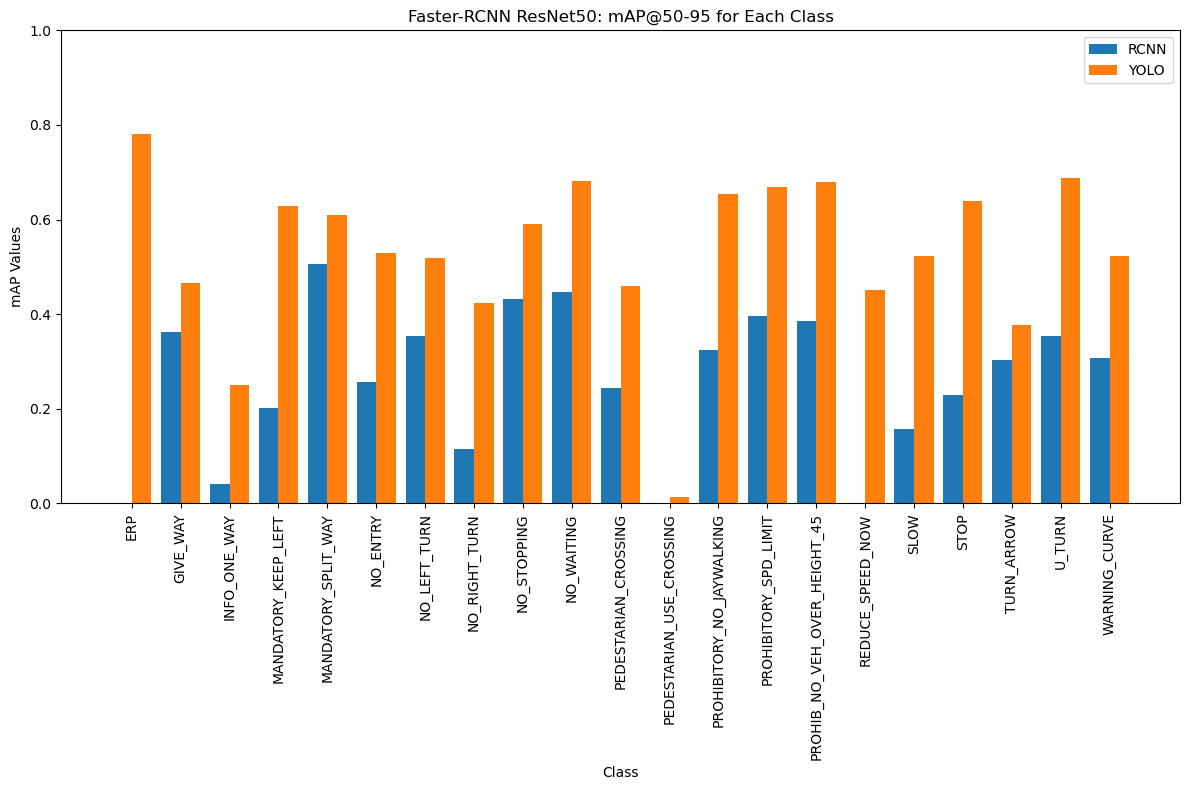

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_YOLO = pd.read_csv("result.csv", encoding="utf-8", sep="\s+")
signs_names = list(df_YOLO.iloc[:,0])

# Create DataFrame
data = {
    'Class': [f'{signs_names[i]}' for i in range(21)],
    'RCNN-mAP@50': [0.0000, 0.7525, 0.1262, 0.3504, 0.8585, 0.4554, 0.5936, 0.2277, 0.6472, 0.8350, 
               0.4653, 0.0000, 0.5854, 0.5941, 0.5792, 0.0000, 0.4224, 0.4720, 0.4554, 0.6417, 0.7921],
    'RCNN-mAP@50-95': [0.0000, 0.3630, 0.0421, 0.2008, 0.5053, 0.2561, 0.3536, 0.1155, 0.4315, 0.4466,
                  0.2450, 0.0000, 0.3249, 0.3960, 0.3861, 0.0000, 0.1573, 0.2295, 0.3036, 0.3542, 0.3069],

    'YOLO-mAP@50': list(df_YOLO.iloc[:,-2]),
    'YOLO-mAP@50-95': list(df_YOLO.iloc[:,-1]),
}

df = pd.DataFrame(data)

# Create bar plot
plt.figure(figsize=(12, 8))
x = np.arange(len(df['Class']))
plt.bar(x-0.2, df['RCNN-mAP@50-95'], width=0.4, label='RCNN', align='center')
plt.bar(x+0.2, df['YOLO-mAP@50-95'], width=0.4, label='YOLO', align='center')

# Customize plot
plt.xlabel('Class')
plt.ylabel('mAP Values')
plt.title('Faster-RCNN ResNet50: mAP@50-95 for Each Class')
plt.xticks(x, df['Class'], rotation=90)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()
